In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path+"/"+"train")

    train_datagen = ImageDataGenerator()

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path+"/"+"train",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    valid_datagen = ImageDataGenerator()
    validation_generator = valid_datagen.flow_from_directory(
        base_path+"/"+"val",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',shuffle=False)
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory(
        base_path+"/"+"test",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', shuffle=False)
    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator,test_generator

In [3]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [4]:
def initiateVGG19(noOfClasses):
    modelInput = tf.keras.applications.VGG19(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [5]:
def initiateDenseNet201(noOfClasses):
    modelInput = tf.keras.applications.DenseNet201(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model


In [6]:
def initiateMobileNetV3(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

In [7]:
def initiateParams(className, model, lr,model_name):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + model_name+'.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint

In [8]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history


In [9]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [10]:
def evalModel(model):
    evl = model.evaluate(test_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    return acc
    
def saveModel(model, className,model_name):
    model.save(className + " - "+model_name+"Final.h5")
    print("Model Saved!")

In [11]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [12]:
from sklearn.metrics import recall_score,precision_score,f1_score
def callPlot(model, className, classes):
    y_true = test_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))
    
    conf_mat = confusion_matrix(y_true, y_pred)
    acc=np.trace(conf_mat) / float(np.sum(conf_mat))
    print(f"ACCURACY={acc}")
    recall=recall_score(y_true,y_pred,average='weighted')
    p=precision_score(y_true, y_pred,average='weighted')
    f1=f1_score(y_true, y_pred,average='weighted')
   
    print(f"RECALL={recall}")
    print(f"precision={p}")
    print(f"F1 Score{f1}")
    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [13]:
mpath = r'../input/multi-cancer/Dataset'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
lr = 0.001

In [14]:
import pprint
part={}
for c in classPaths:
#     part[c]={'models':{"EfficientNetB7":{"model":None,"accurary":0},
#                     "Densenet201":{"model":None,"accurary":0},
#                     "VGG19":{"model":None,"accurary":0},
#                     "ResnetV2":{"model":None,"accurary":0},
#                     "mobilenetV3":{"model":None,"accurary":0}
#                    },'no_of_classes':0,"ClassNames":None}
    part[c]={'models':{},'no_of_classes':0,"ClassNames":None}

In [15]:
pprint.pprint(part)

{'ALL': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Brain Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Breast Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Cervical Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Kidney Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Lung and Colon Cancer': {'ClassNames': None,
                           'models': {},
                           'no_of_classes': 0},
 'Lymphoma': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Oral Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0}}


In [16]:
def Ensemble(c):
    y_true = test_generator.classes
    print("True : ", (y_true))
    pred=[]
    for model,obj in part[c]['models'].items():
        pred.append(obj['model'].predict(test_generator)*obj['Accurary'])
    y_pred=pred[0]
    for i in range(1,len(pred)):
        y_pred=y_pred+pred[i]
        
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)
    acc=np.trace(conf_mat) / float(np.sum(conf_mat))
    print(f"ACCURACY={acc}")
    recall=recall_score(y_true,y_pred,average='weighted')
    p=precision_score(y_true, y_pred,average='weighted')
    f1=f1_score(y_true, y_pred,average='weighted')
    print(f"RECALL={recall}")
    print(f"precision={p}")
    print(f"F1 Score{f1}")

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = part[c]['ClassNames'],
                          title        = c + "Confusion Matrix")

In [17]:
def initiateResNet50V2(noOfClasses):
    modelInput = tf.keras.applications.ResNet50V2(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model


Total :  Found 7000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
######################################################
RESULTS FORVGG-19
80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.9669
Epoch 1: val_loss improved from inf to 0.66128, saving model to Breast CancerVGG-19.h5
219/219 [==============================] - 159s 667ms/step - loss: 0.7417 - accuracy: 0.9669 - val_loss: 0.6613 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.9877
Epoch 2: val_loss did not improve from 0.66128
219/219 [==============================] - 67s 304ms/step - loss: 0.2870 - accur

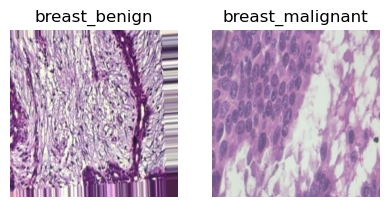

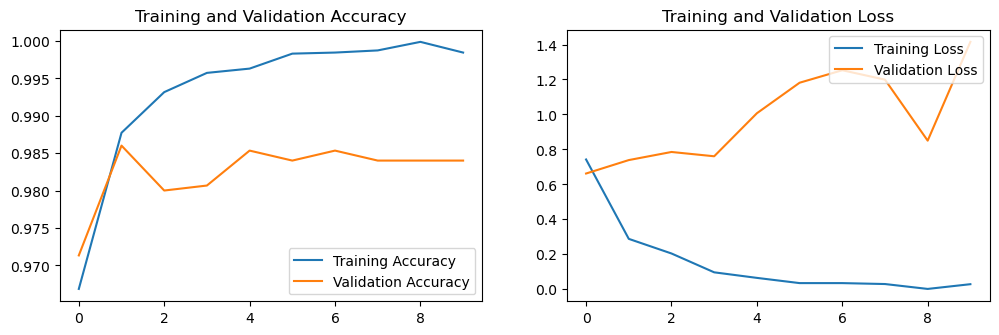

47/47 [==============================] - 27s 578ms/step - loss: 0.5873 - accuracy: 0.9913
Accuracy on the Test Set = 99.13 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 12s 259ms/step
Predicted :  [0 0 0 ... 1 1 1]
ACCURACY=0.9913333333333333
RECALL=0.9913333333333333
precision=0.9914040955230887
F1 Score0.991333021322101


<Figure size 640x480 with 0 Axes>

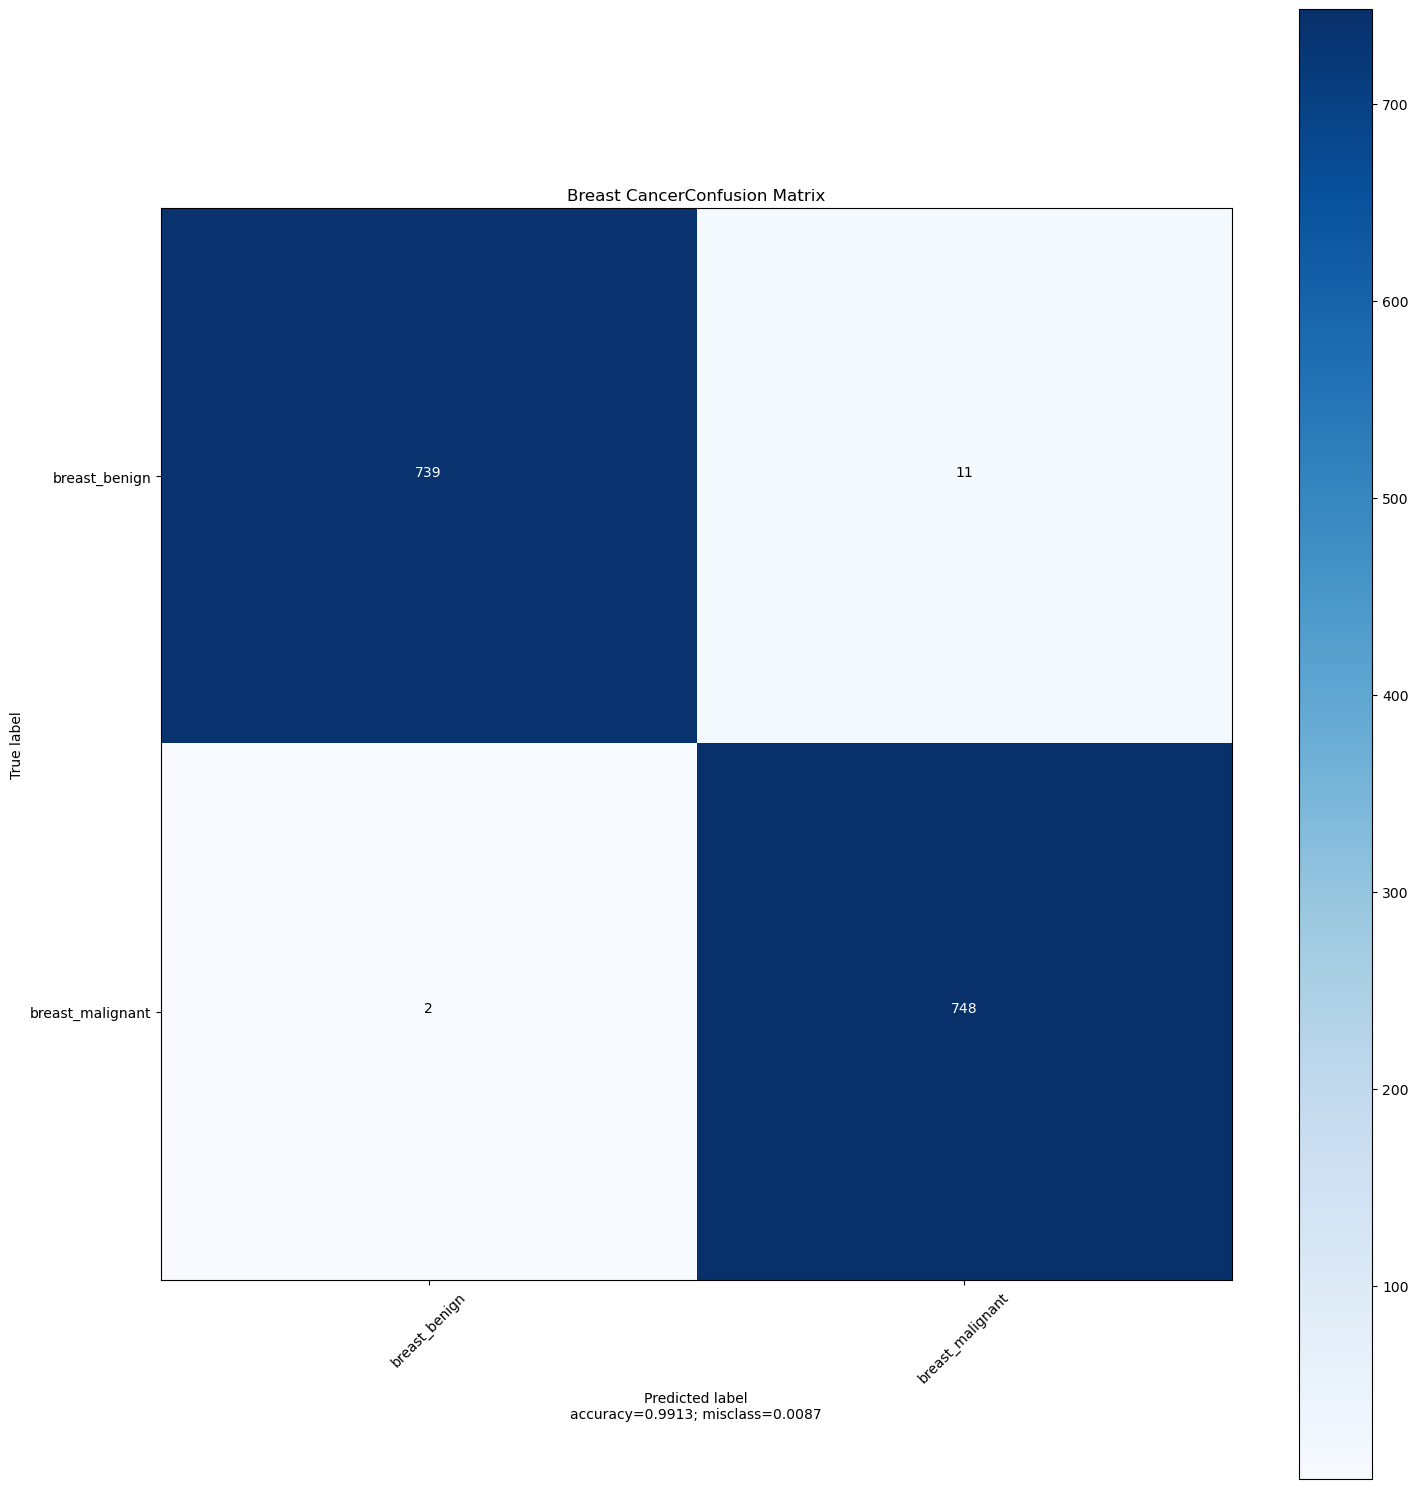

######################################################
RESULTS FORDenseNet201
74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 3.5451 - accuracy: 0.9053
Epoch 1: val_loss improved from inf to 0.53063, saving model to Breast CancerDenseNet201.h5
219/219 [==============================] - 94s 361ms/step - loss: 3.5451 - accuracy: 0.9053 - val_loss: 0.5306 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.8915 - accuracy: 0.9559
Epoch 2: val_loss did not improve from 0.53063
219/219 [==============================] - 66s 302ms/step - loss: 0.8915 - accuracy: 0.9559 - val_loss: 0.5957 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.9720
Epoch 3: val_loss improved from 0.53063 to 0.41691, saving model to Breast CancerDenseNet201.h5
219/219 [==============================]

<Figure size 640x480 with 0 Axes>

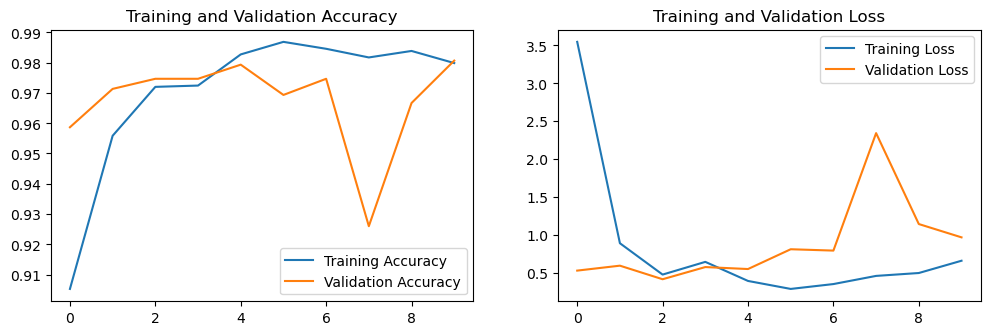

47/47 [==============================] - 13s 273ms/step - loss: 0.8619 - accuracy: 0.9800
Accuracy on the Test Set = 98.00 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 15s 256ms/step
Predicted :  [0 0 0 ... 1 1 1]
ACCURACY=0.98
RECALL=0.98
precision=0.9806699470907005
F1 Score0.9799930286819941


<Figure size 640x480 with 0 Axes>

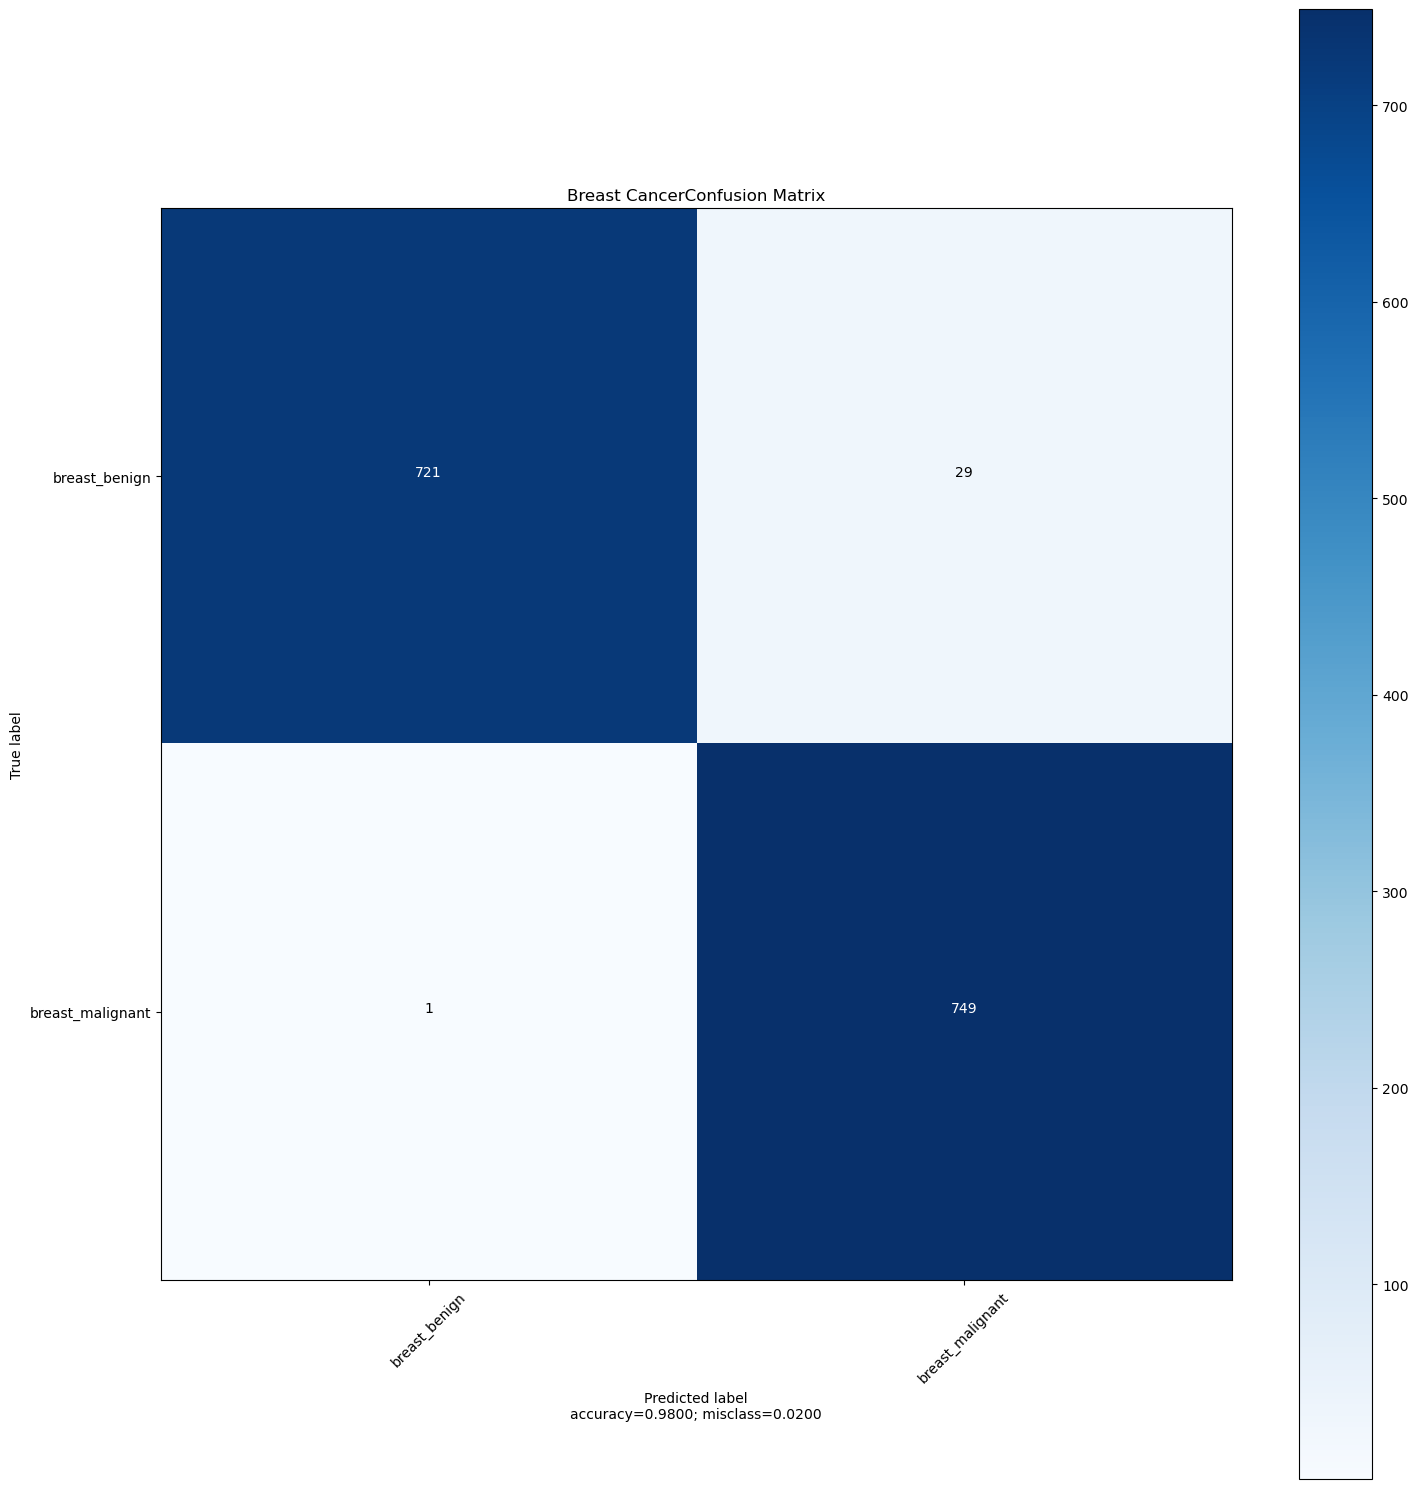

######################################################
RESULTS FORMobileNetV3
4334752/4334752 [==============================] - 0s 0us/step
Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9741
Epoch 1: val_loss improved from inf to 0.19789, saving model to Breast CancerMobileNetV3.h5
219/219 [==============================] - 64s 275ms/step - loss: 0.1655 - accuracy: 0.9741 - val_loss: 0.1979 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9964
Epoch 2: val_loss did not improve from 0.19789
219/219 [==============================] - 58s 265ms/step - loss: 0.0223 - accuracy: 0.9964 - val_loss: 0.2217 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.0127 - accuracy: 0.9973
Epoch 3: val_loss improved from 0.19789 to 0.15147, saving model to Breast CancerMobileNetV3.h5
219/219 [==============================] -

<Figure size 640x480 with 0 Axes>

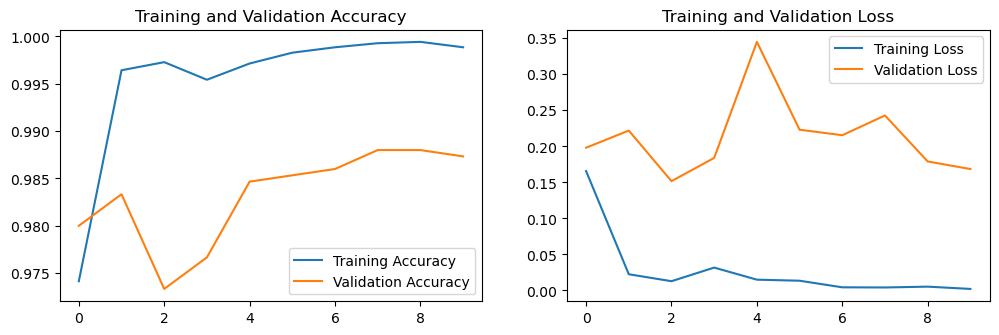

47/47 [==============================] - 11s 241ms/step - loss: 0.1000 - accuracy: 0.9927
Accuracy on the Test Set = 99.27 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 11s 220ms/step
Predicted :  [0 0 0 ... 1 1 1]
ACCURACY=0.9926666666666667
RECALL=0.9926666666666667
precision=0.9926675425200756
F1 Score0.992666663407406


<Figure size 640x480 with 0 Axes>

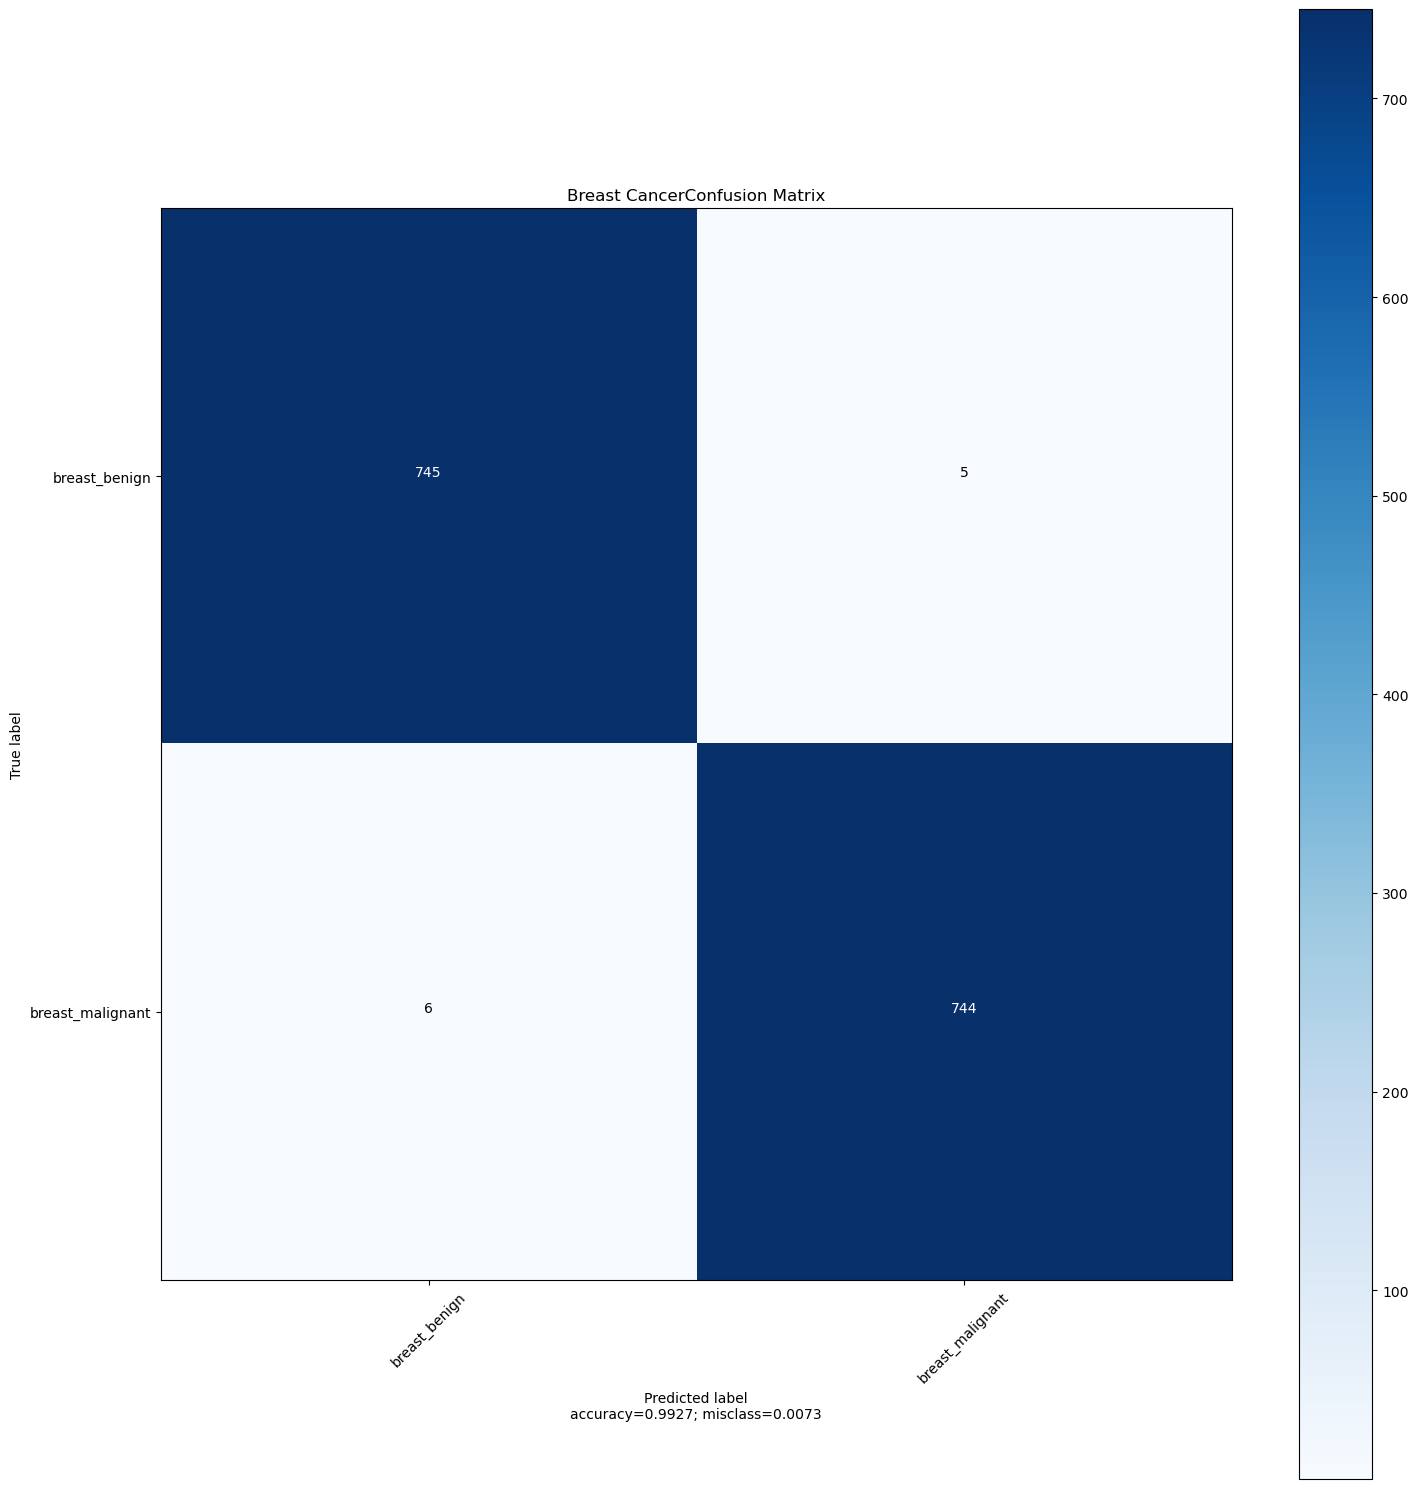

######################################################
RESULTS FORResNet50V2
94668760/94668760 [==============================] - 1s 0us/step
Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 136.0487 - accuracy: 0.7751
Epoch 1: val_loss improved from inf to 89.32771, saving model to Breast CancerResNet50V2.h5
219/219 [==============================] - 70s 296ms/step - loss: 136.0487 - accuracy: 0.7751 - val_loss: 89.3277 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 67.2244 - accuracy: 0.8346
Epoch 2: val_loss improved from 89.32771 to 43.31755, saving model to Breast CancerResNet50V2.h5
219/219 [==============================] - 63s 286ms/step - loss: 67.2244 - accuracy: 0.8346 - val_loss: 43.3176 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 59.7517 - accuracy: 0.8620
Epoch 3: val_loss did not improve from 43.31755
219/219 [=====================

<Figure size 640x480 with 0 Axes>

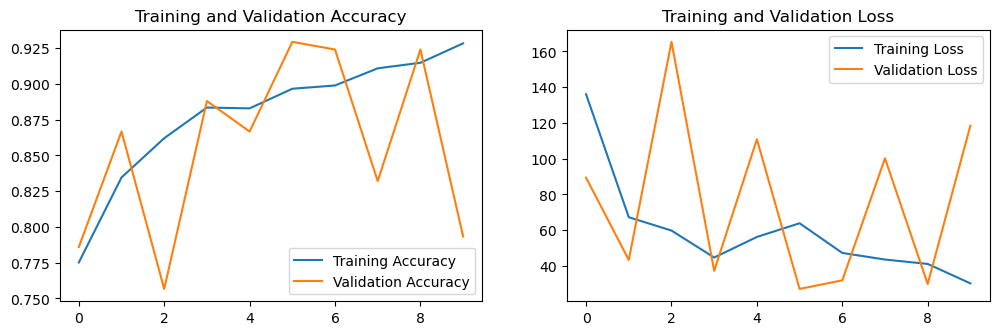

47/47 [==============================] - 12s 257ms/step - loss: 113.0580 - accuracy: 0.7927
Accuracy on the Test Set = 79.27 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 12s 245ms/step
Predicted :  [0 0 0 ... 1 0 0]
ACCURACY=0.7926666666666666
RECALL=0.7926666666666666
precision=0.8479715662049592
F1 Score0.784087653470172


<Figure size 640x480 with 0 Axes>

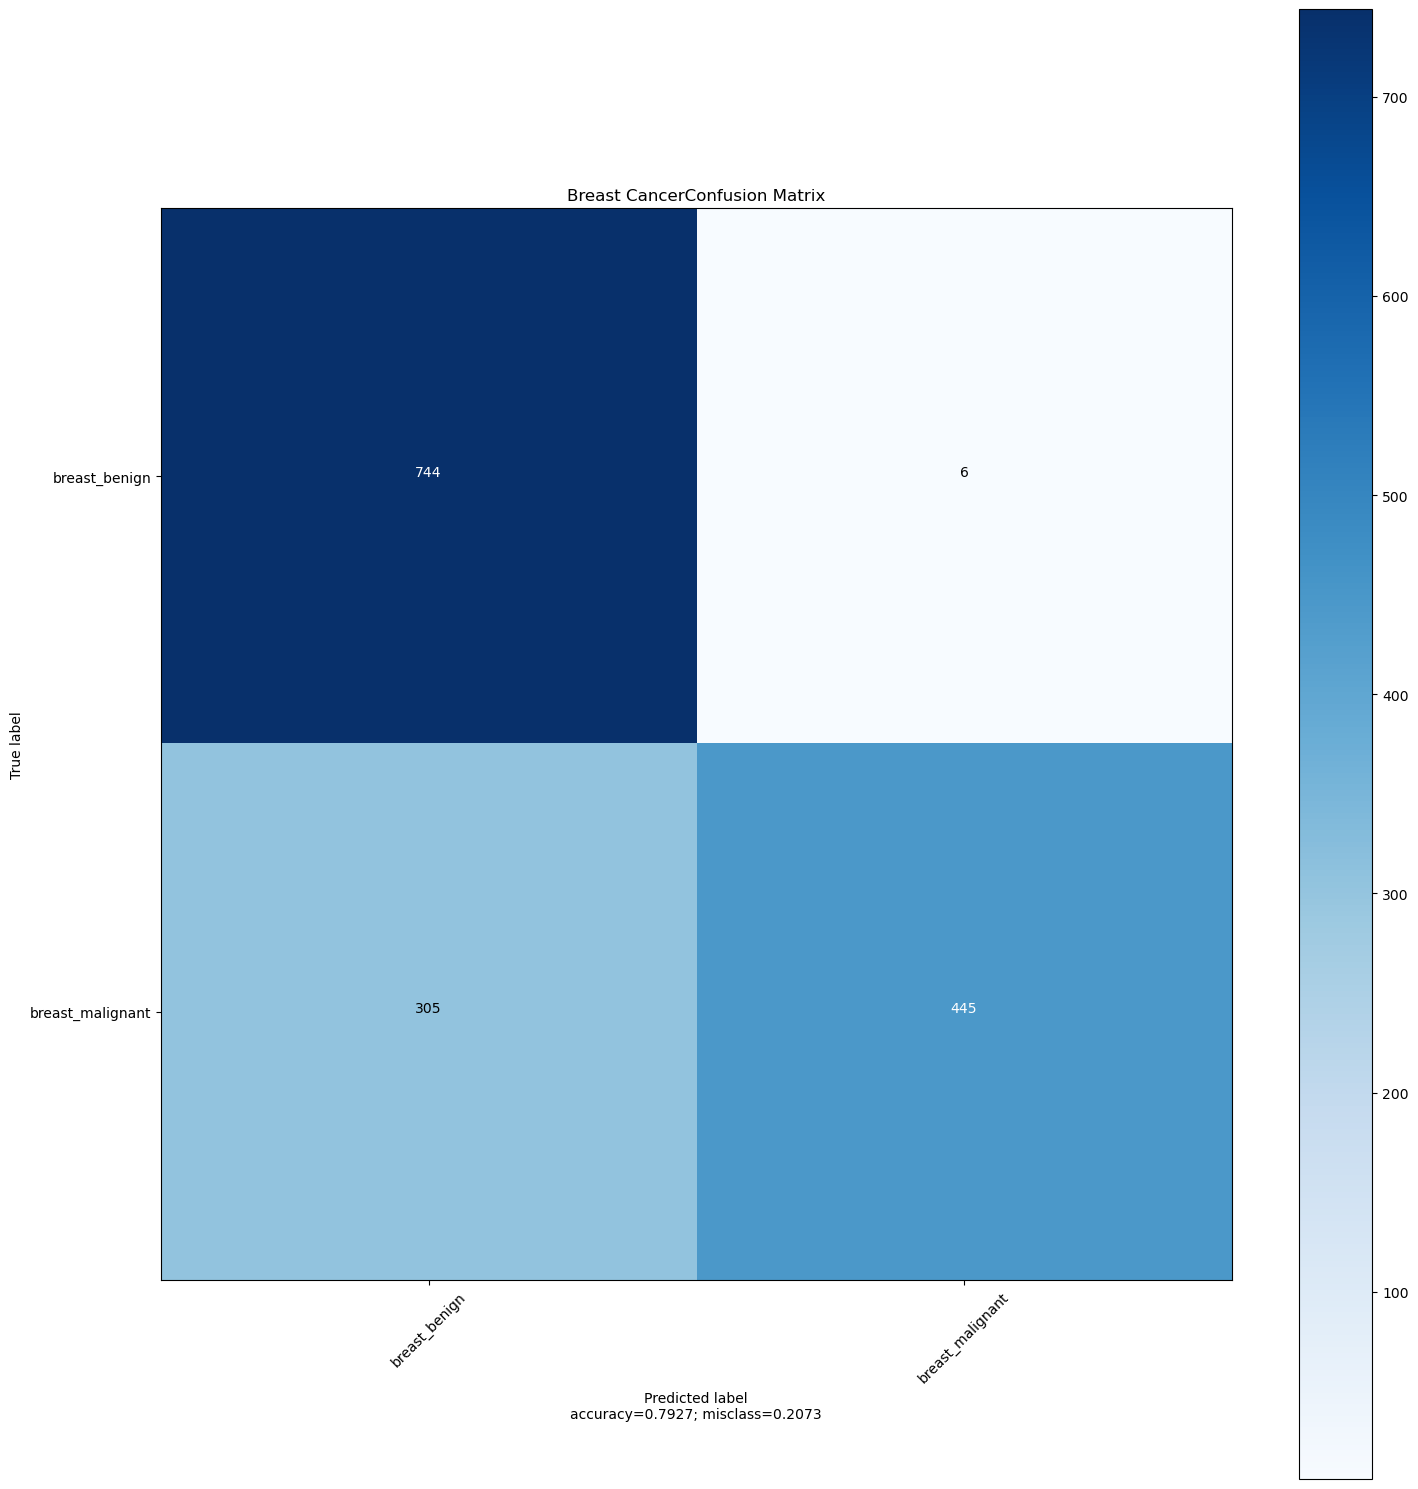

######################################################
RESULTS FOR ENSEMBLE
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 11s 227ms/step
Predicted :  [0 0 0 ... 1 1 1]
ACCURACY=0.9973333333333333
RECALL=0.9973333333333333
precision=0.9973474801061007
F1 Score0.9973333143702354


<Figure size 640x480 with 0 Axes>

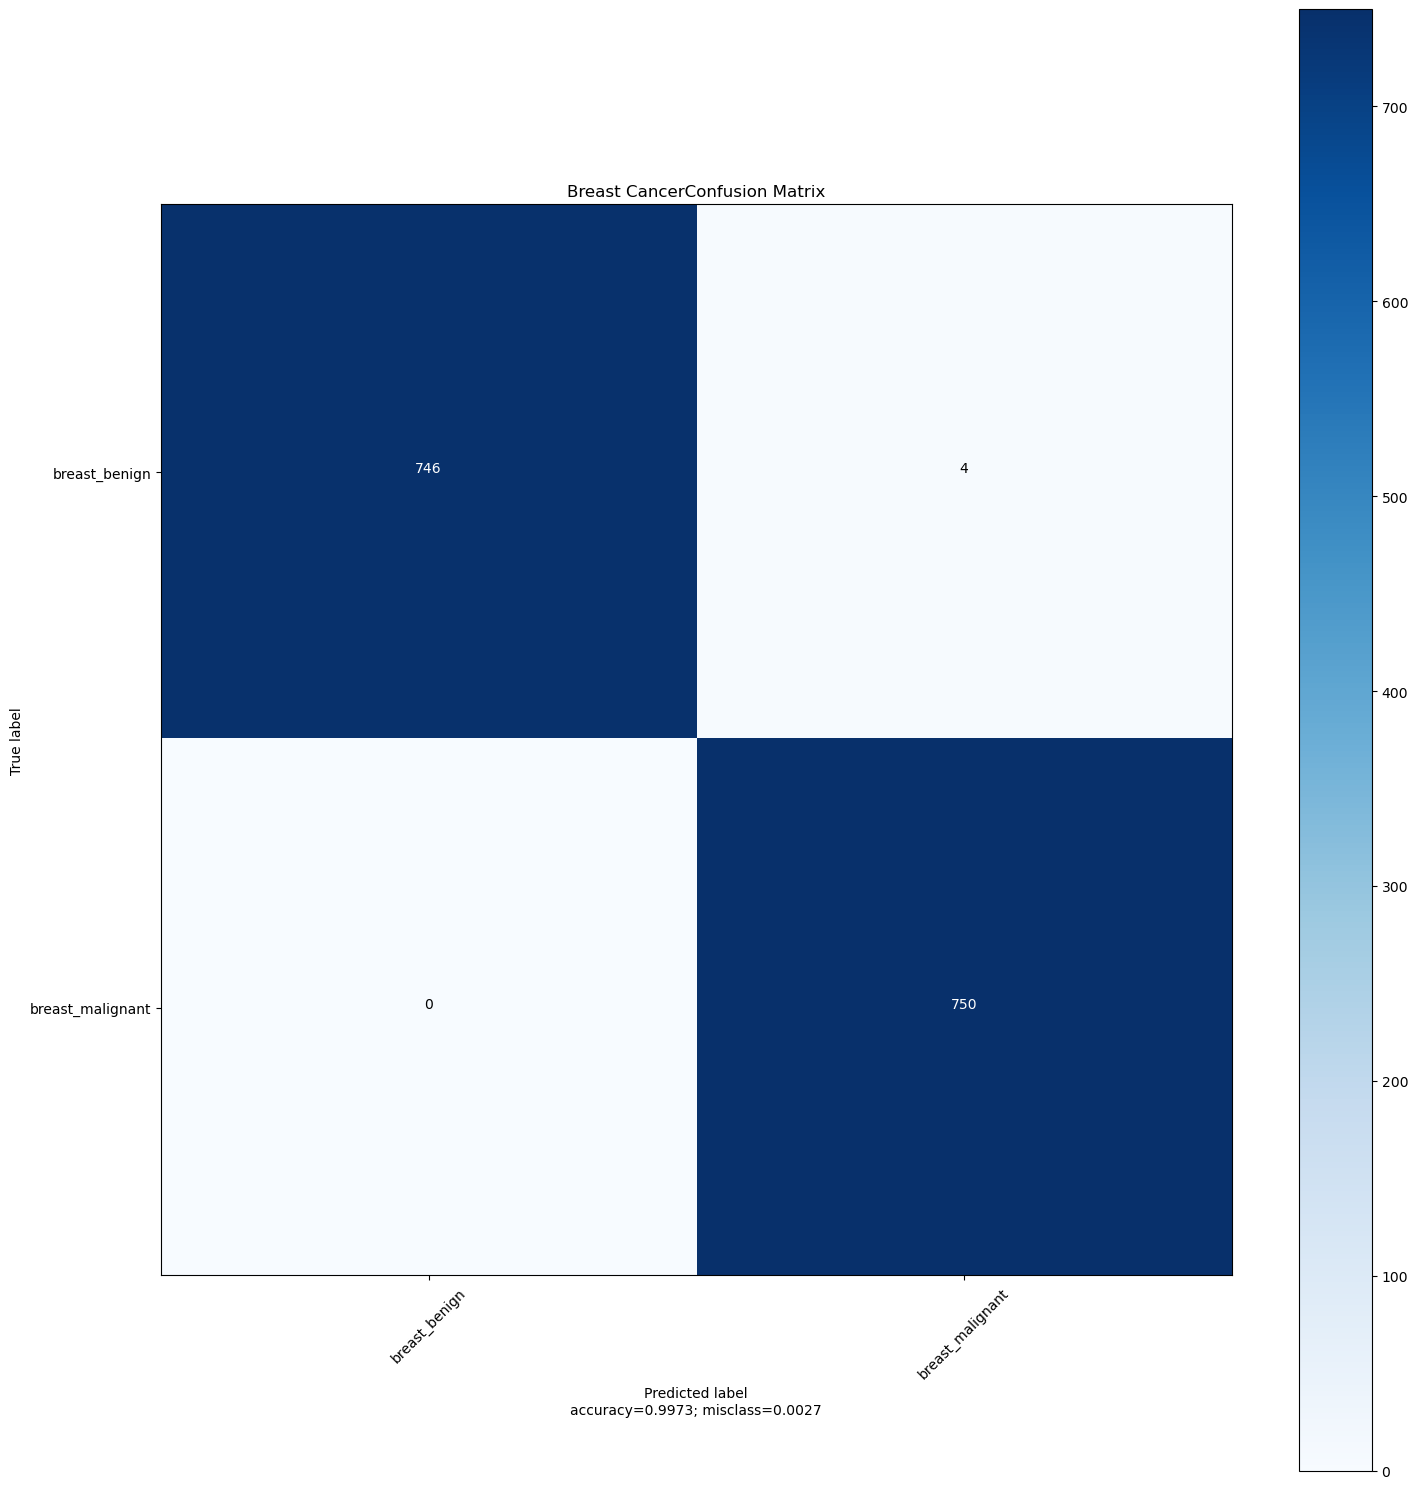

<Figure size 640x480 with 0 Axes>

In [18]:
for c in classPaths[5:6]:
    className = c
#     model_name="VGG-19"
    cpath = os.path.join(mpath, c)
    noOfClasses, class_names, train_generator, validation_generator,test_generator = initiateGenerator(cpath)
    part[c]['ClassNames']=class_names
    
    
    
    model_name="VGG-19"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curVGG19 = initiateVGG19(noOfClasses)
    #modelSummary(curVGG19)
    curVGG19, annealer, checkpoint = initiateParams(className, curVGG19, lr,model_name)
    curHistory = modelFit(curVGG19, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curVGG19)
    
    saveModel(curVGG19, className,model_name)
    part[c]['models']['VGG19']={"model":curVGG19,'Accurary':acc}
    callPlot(curVGG19, className, class_names)
    
    model_name="DenseNet201"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curDenseNet201= initiateDenseNet201(noOfClasses)
    #modelSummary(curDenseNet201)
    curDenseNet201, annealer, checkpoint = initiateParams(className, curDenseNet201, lr,model_name)
    curHistory = modelFit(curDenseNet201, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curDenseNet201)
    saveModel(curDenseNet201, className,model_name)
    part[c]['models']['DenseNet201']={"model":curDenseNet201,'Accurary':acc}
    callPlot(curDenseNet201, className, class_names)
    
    
    
    model_name="MobileNetV3"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curMobileNetV3 = initiateMobileNetV3(noOfClasses)
    #modelSummary(curMobileNetV3)
    curMobileNetV3, annealer, checkpoint = initiateParams(className, curMobileNetV3, lr,model_name)
    curHistory = modelFit(curMobileNetV3, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curMobileNetV3)
    saveModel(curMobileNetV3, className,model_name)
    part[c]['models']['MobileNetV3']={"model":curMobileNetV3,'Accurary':acc}
    callPlot(curMobileNetV3, className, class_names)
    
    model_name="ResNet50V2"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curResNet50V2 = initiateResNet50V2(noOfClasses)
    #modelSummary(curResNet50V2)
    curResNet50V2, annealer, checkpoint = initiateParams(className, curResNet50V2, lr,model_name)
    curHistory = modelFit(curResNet50V2, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curResNet50V2)
    saveModel(curResNet50V2, className,model_name)
    part[c]['models']['ResNet50V2']={"model":curResNet50V2,'Accurary':acc}
    callPlot(curResNet50V2, className, class_names)
    print("######################################################")
    print(f"RESULTS FOR ENSEMBLE")
    Ensemble(c)
    
    
    